In [1]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
%matplotlib inline
# Scale the data
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
# Scale the data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import pandas as pd
import seaborn as sns

# 1. Download the CIFAR-10 dataset or load using keras.

In [2]:
(X, y), _ = tf.keras.datasets.cifar10.load_data()

# 2. Split the datasets into training and test sets.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Analyze the dataset using tables and graphs

In [4]:
X_train.shape

(40000, 32, 32, 3)

In [5]:
X_test.shape

(10000, 32, 32, 3)

In [6]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([4027, 4021, 3970, 3977, 4067, 3985, 4004, 4006, 3983, 3960],
       dtype=int64))

In [7]:
uniques = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
distribution = np.unique(y_test, return_counts=True)[1]

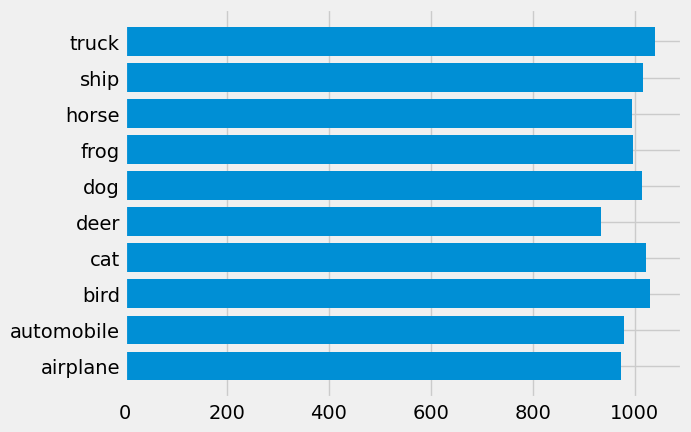

In [8]:
plt.barh(uniques,distribution)
plt.show()

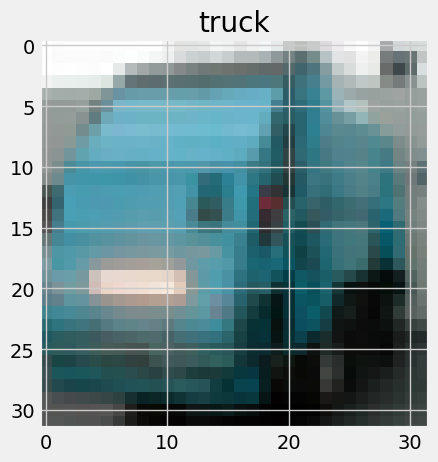

In [9]:
plt.title(uniques[y_train[35][0]])
plt.imshow(X_train[35])

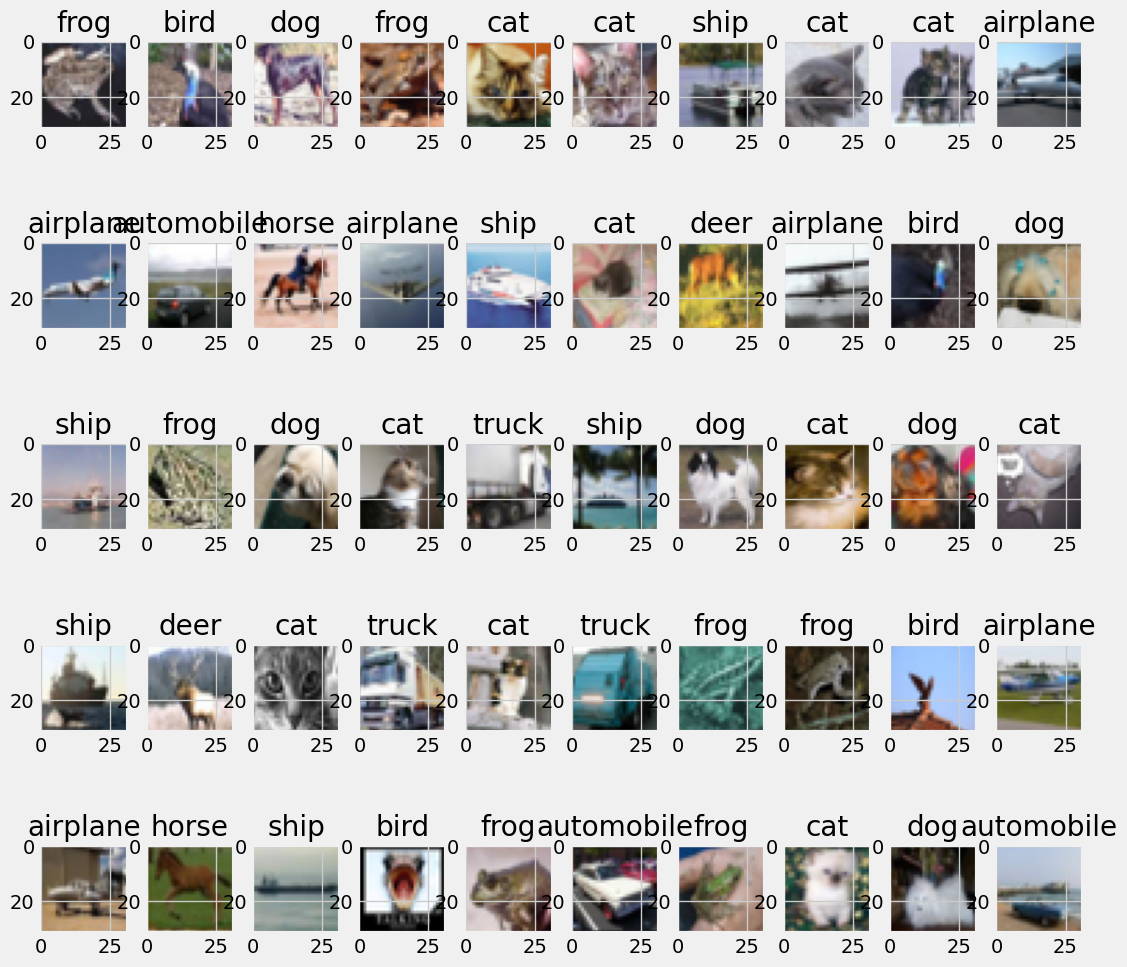

In [10]:
k=1
plt.figure(figsize=(12,12))
for i in range(50):
    plt.subplot(5,10,k)
    plt.title(uniques[y_train[i][0]])
    plt.imshow(X_train[i])
    k+=1

# 4. Clearly explain analysis results.

When we look at the data set, we see a properly adjusted data in place. We have a data set consisting of 50 thousand 32x32 rgb photos, 40 thousand of which will be train and 10 thousand test. There are 10 different labels in this data set. we currently have a classification problem. For this, before preparing our model, we should examine it and get away from data and values ​​that may adversely affect the model. For this, first of all, we created a table to observe if there is any class orientation and we looked at the data distribution. As a result, we learned that there is no orientation to any data set, and there are generally equal numbers of all. When we look at a general table, we see that the labeling is correct.

# 5. Perform preprocessing steps that may be necessary to clean or filter the data.

In [11]:
X_trainR = np.reshape(X_train, (X_train.shape[0], -1))
X_testR = np.reshape(X_test, (X_test.shape[0], -1))

Performing PCA for reducing dimension

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
X_train_pca = pca.fit_transform(X_trainR)
X_test_pca = pca.transform(X_testR)

In [13]:
scaler = StandardScaler()
X_trainS = scaler.fit_transform(X_train_pca)
X_testS = scaler.transform(X_test_pca)

# 6. Apply the KNN and SVM classification algorithm.(apply cross-validation)

SVM

In [14]:
param_grid = {'C': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}

# Use GridSearchCV to find the best hyperparameters for your SVM model
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)

# fitting the model for grid search 
grid.fit(X_trainS, y_train.ravel()) 
 
# print best parameter after tuning 
print(grid.best_params_) 

{'C': 1, 'kernel': 'rbf'}


In [15]:
grid_predictions = grid.predict(X_testS) 
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.55      0.58      0.57       973
           1       0.56      0.61      0.58       979
           2       0.44      0.37      0.40      1030
           3       0.39      0.39      0.39      1023
           4       0.43      0.43      0.43       933
           5       0.45      0.40      0.42      1015
           6       0.51      0.62      0.56       996
           7       0.58      0.54      0.56       994
           8       0.65      0.66      0.66      1017
           9       0.58      0.58      0.58      1040

    accuracy                           0.52     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.51      0.52      0.51     10000



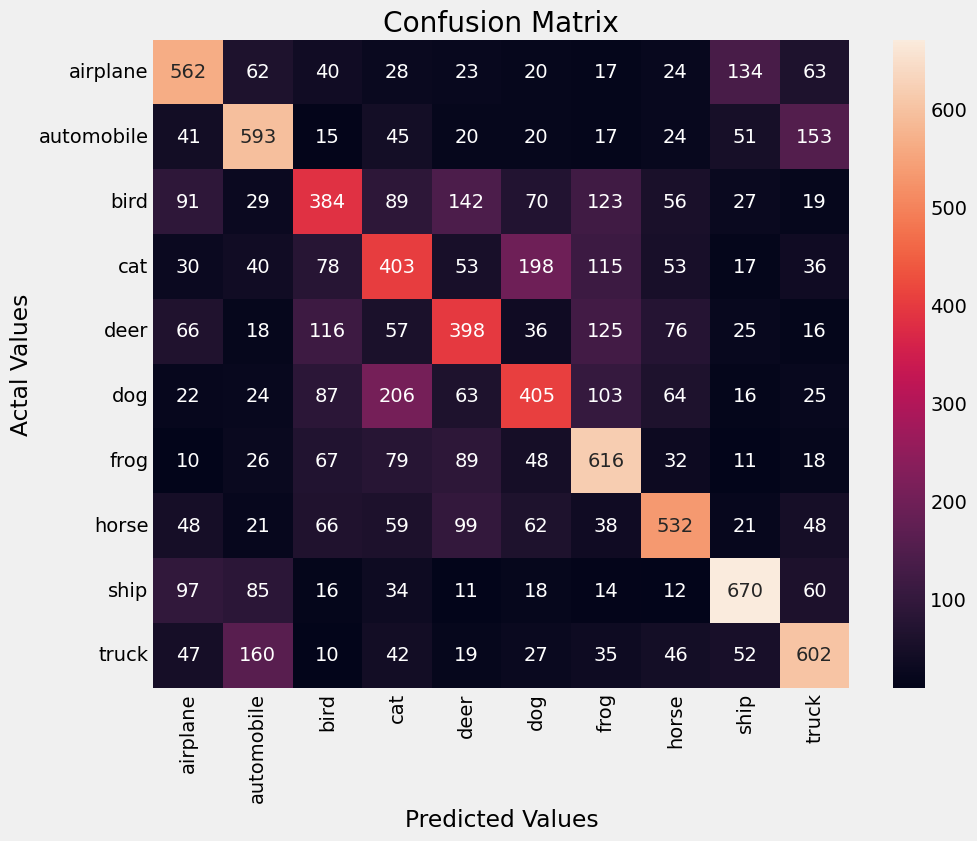

In [16]:
cm = metrics.confusion_matrix(y_test,grid_predictions)
cm_df = pd.DataFrame(cm,
                     index = uniques, 
                     columns = uniques)
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt = 'g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

KNN

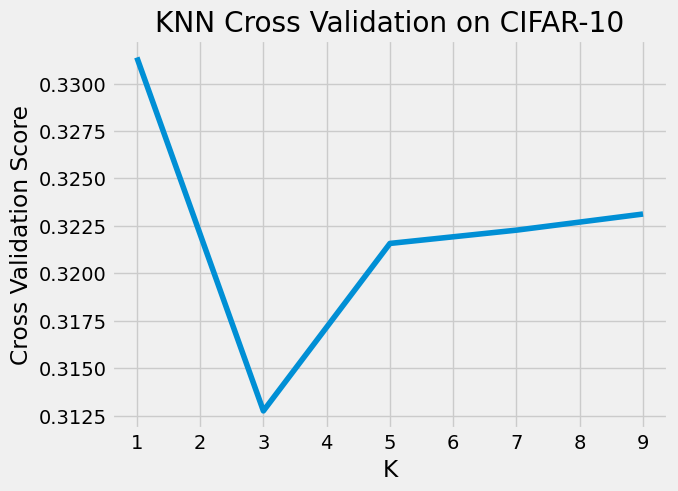

In [17]:
# Set the K values to test
k_values = [1, 3, 5, 7, 9]

# Create an empty list to store the cross validation scores for each K value
cv_scores = []

# Apply cross validation for each K value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_trainR, y_train.ravel(), cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot the cross validation scores for each K value
plt.plot(k_values, cv_scores)
plt.xlabel('K')
plt.ylabel('Cross Validation Score')
plt.title('KNN Cross Validation on CIFAR-10')
plt.show()

In [18]:
# Find the optimal K value with the highest cross validation score
optimal_k = k_values[np.argmax(cv_scores)]
print("The optimal K value is:", optimal_k)

# Train the KNN model with the optimal K value on the entire training set
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_trainR, y_train.ravel())

# Test the KNN model on the test set
knn_pred = knn.predict(X_testR)
# print classification report 
print(classification_report(y_test, knn_pred)) 

The optimal K value is: 1
              precision    recall  f1-score   support

           0       0.40      0.47      0.43       973
           1       0.64      0.20      0.31       979
           2       0.24      0.35      0.29      1030
           3       0.26      0.22      0.24      1023
           4       0.23      0.47      0.31       933
           5       0.35      0.29      0.32      1015
           6       0.33      0.33      0.33       996
           7       0.54      0.25      0.34       994
           8       0.38      0.60      0.47      1017
           9       0.56      0.17      0.26      1040

    accuracy                           0.34     10000
   macro avg       0.39      0.34      0.33     10000
weighted avg       0.39      0.34      0.33     10000



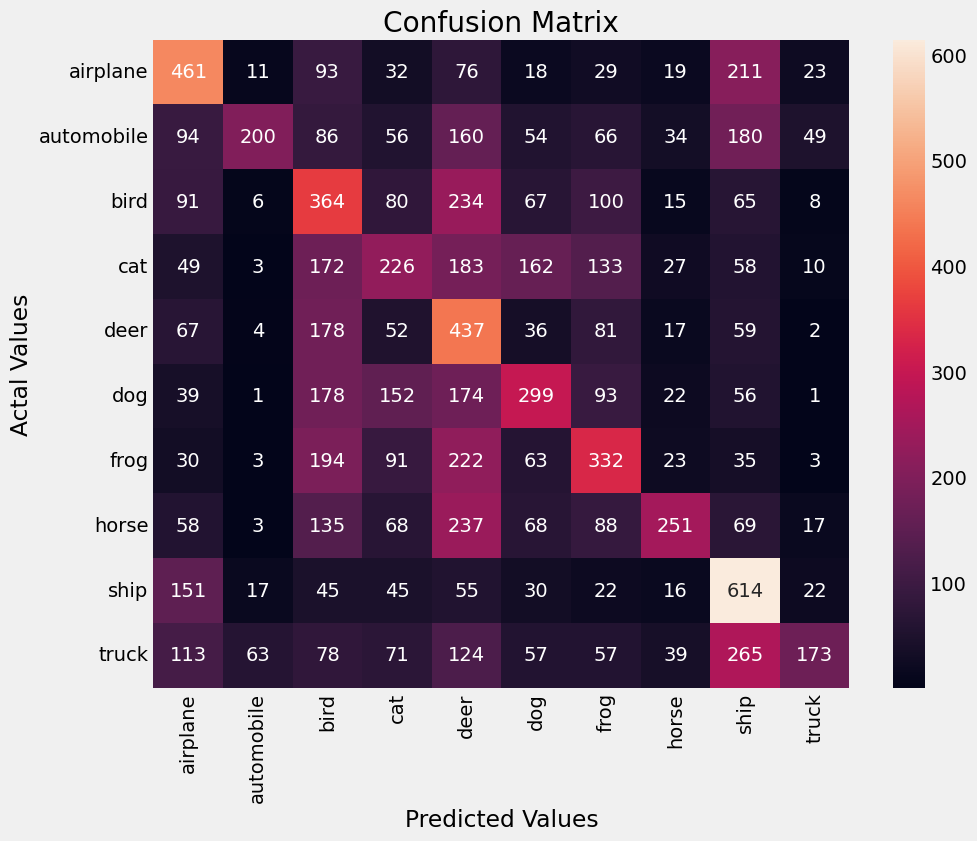

In [19]:
cm = metrics.confusion_matrix(y_test,knn_pred)
cm_df = pd.DataFrame(cm,
                     index = uniques, 
                     columns = uniques)
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt = 'g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# 7. Design your own Neural Network model

# a. decide the number of layers, hidden units(neurons).

# MODEL1

In [20]:
import tensorflow as tf
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [21]:
# Reshape X to 2D array
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Define the model
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
1250/1250 [==============================] - 20s 15ms/step - loss: 1.9971 - accuracy: 0.2634 - val_loss: 1.8390 - val_accuracy: 0.3395
Epoch 2/50
1250/1250 [==============================] - 22s 17ms/step - loss: 1.8715 - accuracy: 0.3161 - val_loss: 1.7991 - val_accuracy: 0.3505
Epoch 3/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.8297 - accuracy: 0.3336 - val_loss: 1.7562 - val_accuracy: 0.3776
Epoch 4/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.8073 - accuracy: 0.3424 - val_loss: 1.7624 - val_accuracy: 0.3651
Epoch 5/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.7903 - accuracy: 0.3453 - val_loss: 1.7211 - val_accuracy: 0.3771
Epoch 6/50
1250/1250 [==============================] - 19s 15ms/step - loss: 1.7749 - accuracy: 0.3516 - val_loss: 1.6967 - val_accuracy: 0.3964
Epoch 7/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.7572 - accuracy: 0.3580 - val_loss: 1.6942 -

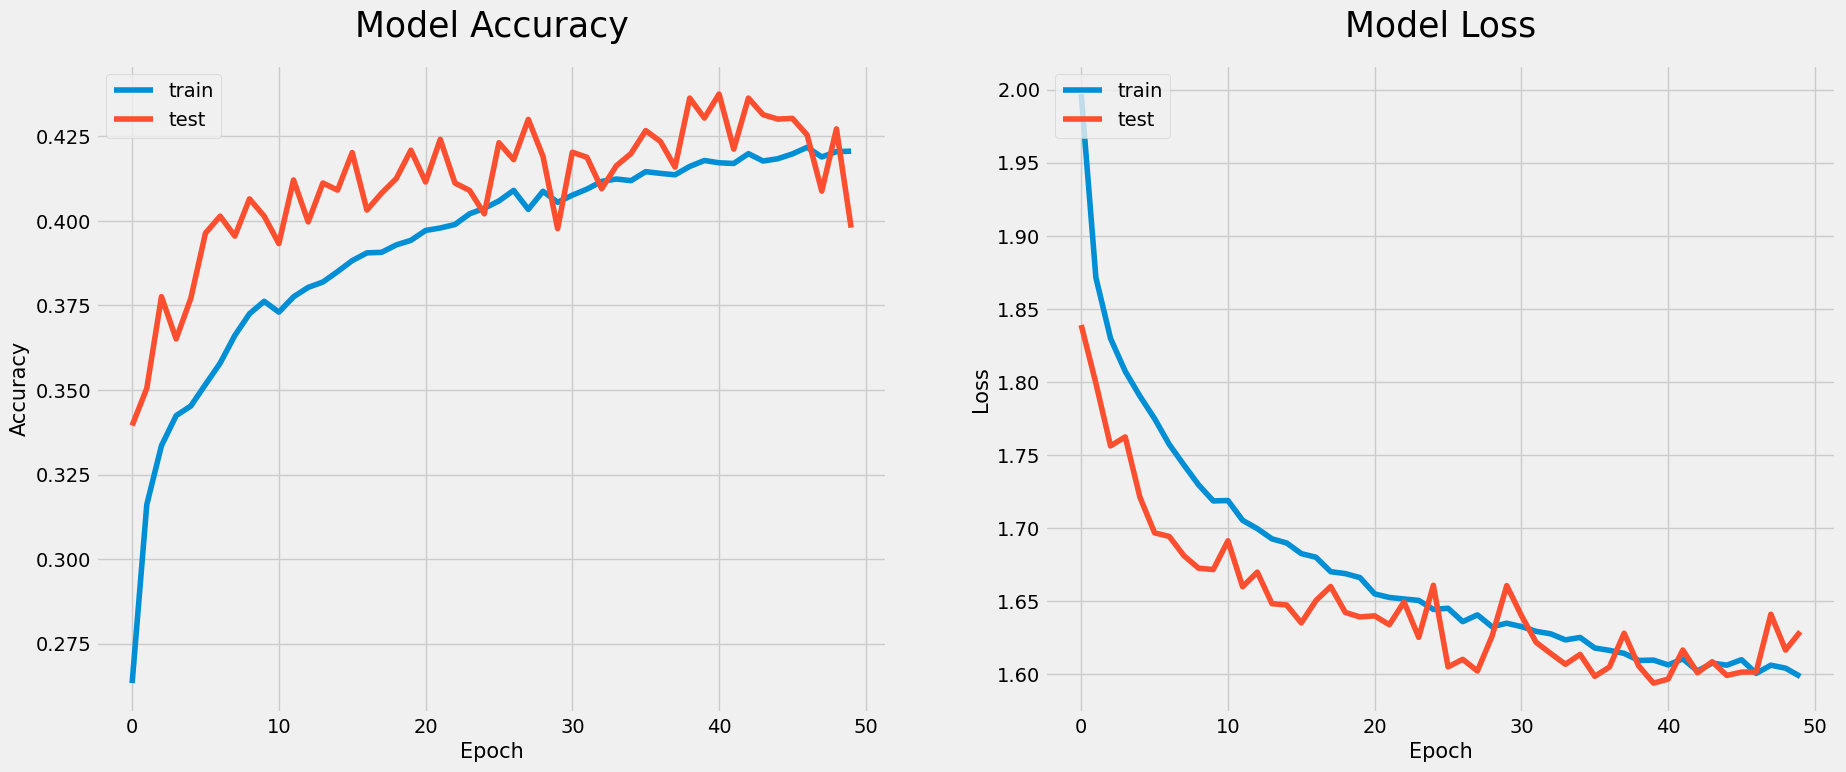

In [22]:
# Plotting the Model Accuracy & Model Loss vs Epochs (Hidden Input)
plt.figure(figsize=[20,8])

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# Predict probabilities for test set
y_prob = model.predict(X_test)

# Get predicted class labels
model_pred = y_prob.argmax(axis=-1)
print(classification_report(y_test, model_pred)) 

313/313 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.66      0.17      0.27      1000
           1       0.68      0.34      0.46      1000
           2       0.34      0.24      0.28      1000
           3       0.24      0.37      0.29      1000
           4       0.38      0.24      0.29      1000
           5       0.46      0.26      0.33      1000
           6       0.36      0.63      0.46      1000
           7       0.52      0.44      0.48      1000
           8       0.42      0.70      0.53      1000
           9       0.41      0.64      0.50      1000

    accuracy                           0.40     10000
   macro avg       0.45      0.40      0.39     10000
weighted avg       0.45      0.40      0.39     10000



# MODEL2

In [24]:
# Define the model
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
1250/1250 [==============================] - 19s 14ms/step - loss: 2.0215 - accuracy: 0.2526 - val_loss: 1.8679 - val_accuracy: 0.3173
Epoch 2/50
1250/1250 [==============================] - 16s 13ms/step - loss: 1.9058 - accuracy: 0.2998 - val_loss: 1.8252 - val_accuracy: 0.3391
Epoch 3/50
1250/1250 [==============================] - 14s 12ms/step - loss: 1.8590 - accuracy: 0.3196 - val_loss: 1.8102 - val_accuracy: 0.3373
Epoch 4/50
1250/1250 [==============================] - 13s 11ms/step - loss: 1.8453 - accuracy: 0.3224 - val_loss: 1.8206 - val_accuracy: 0.3540
Epoch 5/50
1250/1250 [==============================] - 13s 10ms/step - loss: 1.8318 - accuracy: 0.3319 - val_loss: 1.7678 - val_accuracy: 0.3751
Epoch 6/50
1250/1250 [==============================] - 13s 11ms/step - loss: 1.8120 - accuracy: 0.3360 - val_loss: 1.7478 - val_accuracy: 0.3739
Epoch 7/50
1250/1250 [==============================] - 13s 10ms/step - loss: 1.8012 - accuracy: 0.3403 - val_loss: 1.7826 -

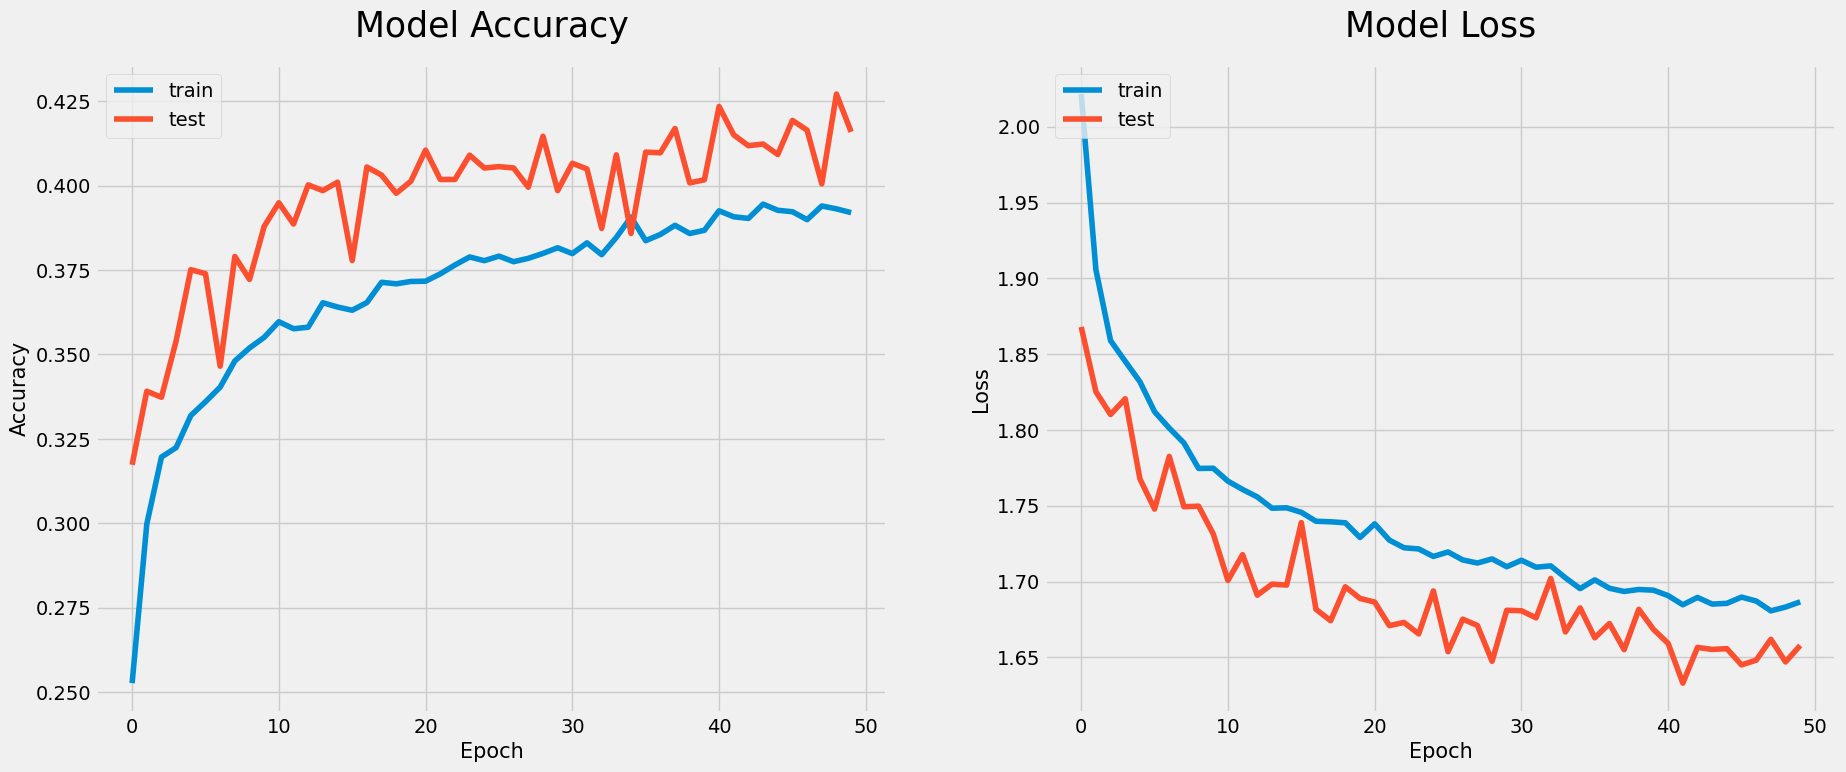

In [25]:
# Plotting the Model Accuracy & Model Loss vs Epochs (Hidden Input)
plt.figure(figsize=[20,8])

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# Predict probabilities for test set
y_prob = model.predict(X_test)

# Get predicted class labels
model_pred = y_prob.argmax(axis=-1)
print(classification_report(y_test, model_pred)) 

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.59      0.35      0.44      1000
           1       0.57      0.48      0.52      1000
           2       0.30      0.22      0.26      1000
           3       0.25      0.42      0.31      1000
           4       0.37      0.35      0.36      1000
           5       0.49      0.19      0.28      1000
           6       0.38      0.59      0.46      1000
           7       0.46      0.51      0.49      1000
           8       0.57      0.50      0.53      1000
           9       0.45      0.59      0.51      1000

    accuracy                           0.42     10000
   macro avg       0.44      0.42      0.42     10000
weighted avg       0.44      0.42      0.42     10000



# MODEL3

In [27]:
# Define the model
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
1250/1250 [==============================] - 27s 21ms/step - loss: 1.9764 - accuracy: 0.2808 - val_loss: 1.8414 - val_accuracy: 0.3372
Epoch 2/50
1250/1250 [==============================] - 23s 18ms/step - loss: 1.8359 - accuracy: 0.3331 - val_loss: 1.7693 - val_accuracy: 0.3647
Epoch 3/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.7914 - accuracy: 0.3549 - val_loss: 1.7513 - val_accuracy: 0.3771
Epoch 4/50
1250/1250 [==============================] - 22s 18ms/step - loss: 1.7577 - accuracy: 0.3677 - val_loss: 1.7141 - val_accuracy: 0.3906
Epoch 5/50
1250/1250 [==============================] - 19s 15ms/step - loss: 1.7411 - accuracy: 0.3717 - val_loss: 1.6896 - val_accuracy: 0.4032
Epoch 6/50
1250/1250 [==============================] - 19s 15ms/step - loss: 1.7225 - accuracy: 0.3824 - val_loss: 1.6641 - val_accuracy: 0.4137
Epoch 7/50
1250/1250 [==============================] - 22s 18ms/step - loss: 1.7060 - accuracy: 0.3850 - val_loss: 1.6582 -

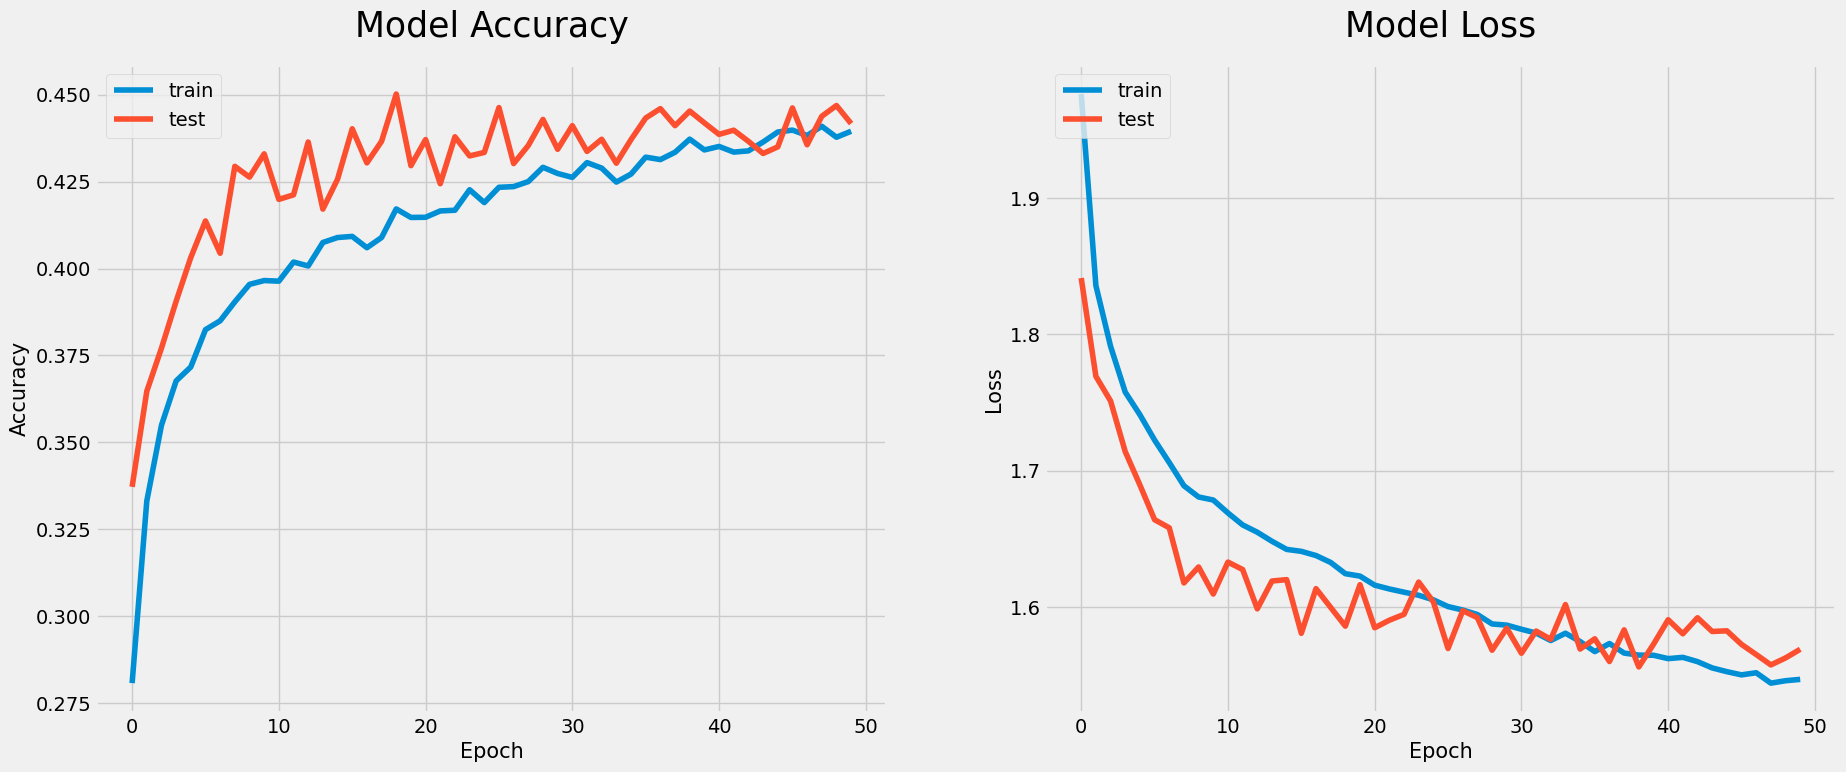

In [28]:
# Plotting the Model Accuracy & Model Loss vs Epochs (Hidden Input)
plt.figure(figsize=[20,8])

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
# Predict probabilities for test set
y_prob = model.predict(X_test)

# Get predicted class labels
model_pred = y_prob.argmax(axis=-1)
print(classification_report(y_test, model_pred)) 

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.54      0.45      0.49      1000
           1       0.57      0.57      0.57      1000
           2       0.30      0.25      0.28      1000
           3       0.34      0.24      0.28      1000
           4       0.34      0.53      0.41      1000
           5       0.46      0.22      0.30      1000
           6       0.44      0.52      0.48      1000
           7       0.49      0.51      0.50      1000
           8       0.49      0.68      0.57      1000
           9       0.52      0.50      0.51      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.44     10000
weighted avg       0.45      0.45      0.44     10000



# b. try different optimization functions and select one.

In [30]:
import tensorflow as tf
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Reshape X to 2D array
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# b.1 Lets try sgd

In [31]:
# Define the model
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
1250/1250 [==============================] - 11s 8ms/step - loss: 1.9516 - accuracy: 0.2942 - val_loss: 1.8118 - val_accuracy: 0.3505
Epoch 2/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.7803 - accuracy: 0.3637 - val_loss: 1.7668 - val_accuracy: 0.3792
Epoch 3/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.7093 - accuracy: 0.3923 - val_loss: 1.7123 - val_accuracy: 0.3853
Epoch 4/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6554 - accuracy: 0.4128 - val_loss: 1.6217 - val_accuracy: 0.4290
Epoch 5/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6186 - accuracy: 0.4272 - val_loss: 1.5817 - val_accuracy: 0.4412
Epoch 6/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5872 - accuracy: 0.4385 - val_loss: 1.5661 - val_accuracy: 0.4482
Epoch 7/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5563 - accuracy: 0.4487 - val_loss: 1.5543 - val_ac

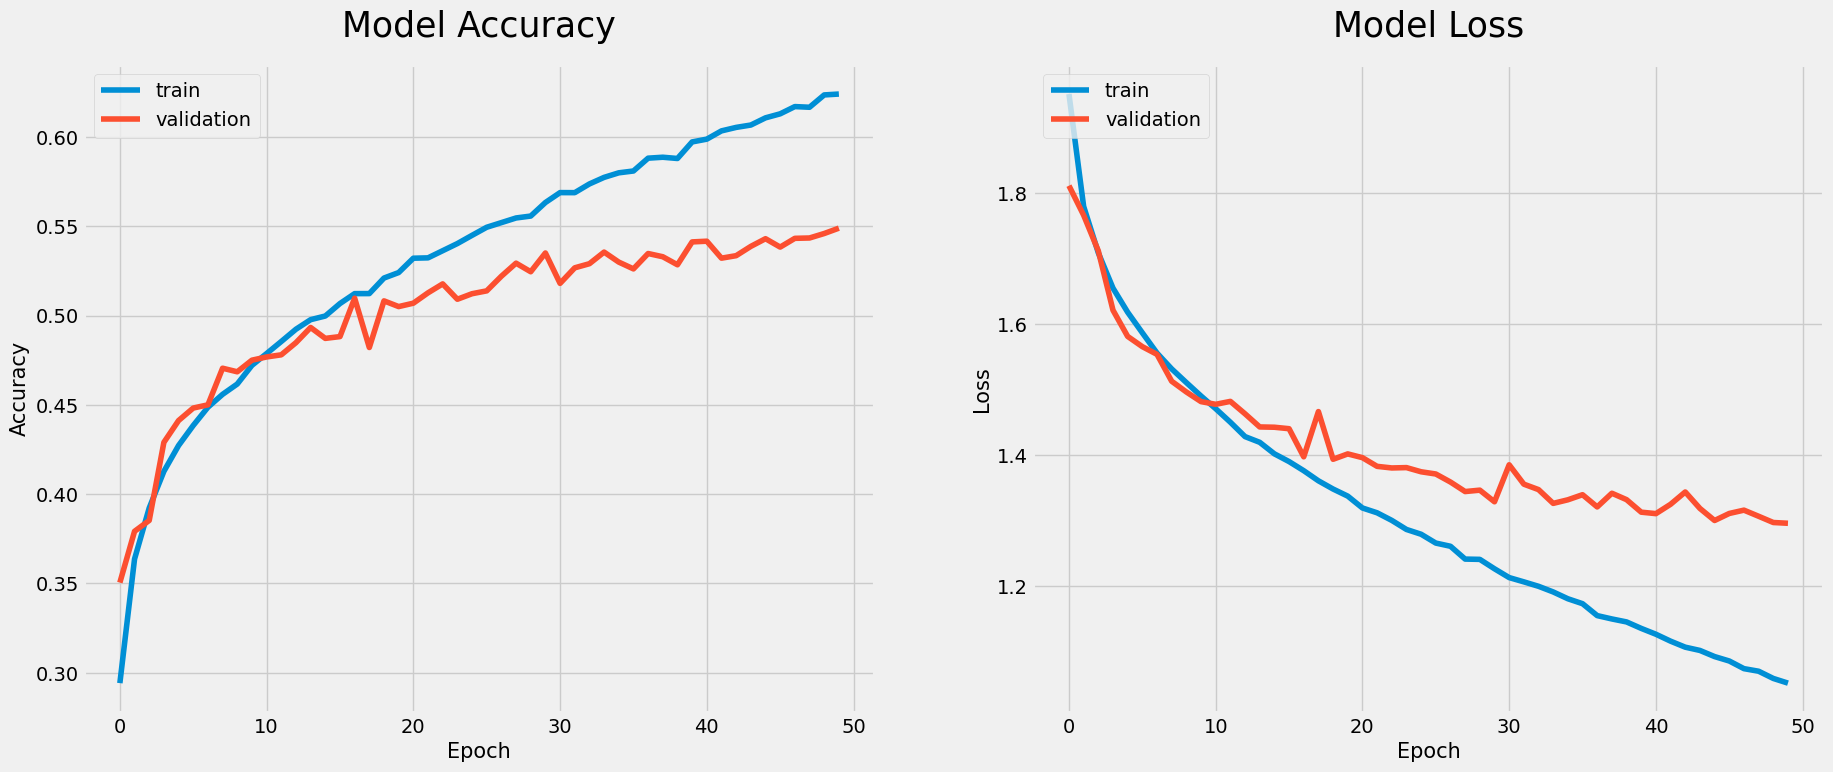

In [32]:
# Plotting the Model Accuracy & Model Loss vs Epochs (Hidden Input)
plt.figure(figsize=[20,8])

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
# Predict probabilities for test set
y_prob = model.predict(X_test)

# Get predicted class labels
model_pred = y_prob.argmax(axis=-1)
print(classification_report(y_test, model_pred)) 

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.66      0.57      0.62      1000
           1       0.66      0.67      0.66      1000
           2       0.51      0.33      0.40      1000
           3       0.38      0.37      0.37      1000
           4       0.47      0.51      0.49      1000
           5       0.46      0.47      0.46      1000
           6       0.53      0.68      0.60      1000
           7       0.63      0.60      0.62      1000
           8       0.64      0.71      0.67      1000
           9       0.58      0.61      0.60      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



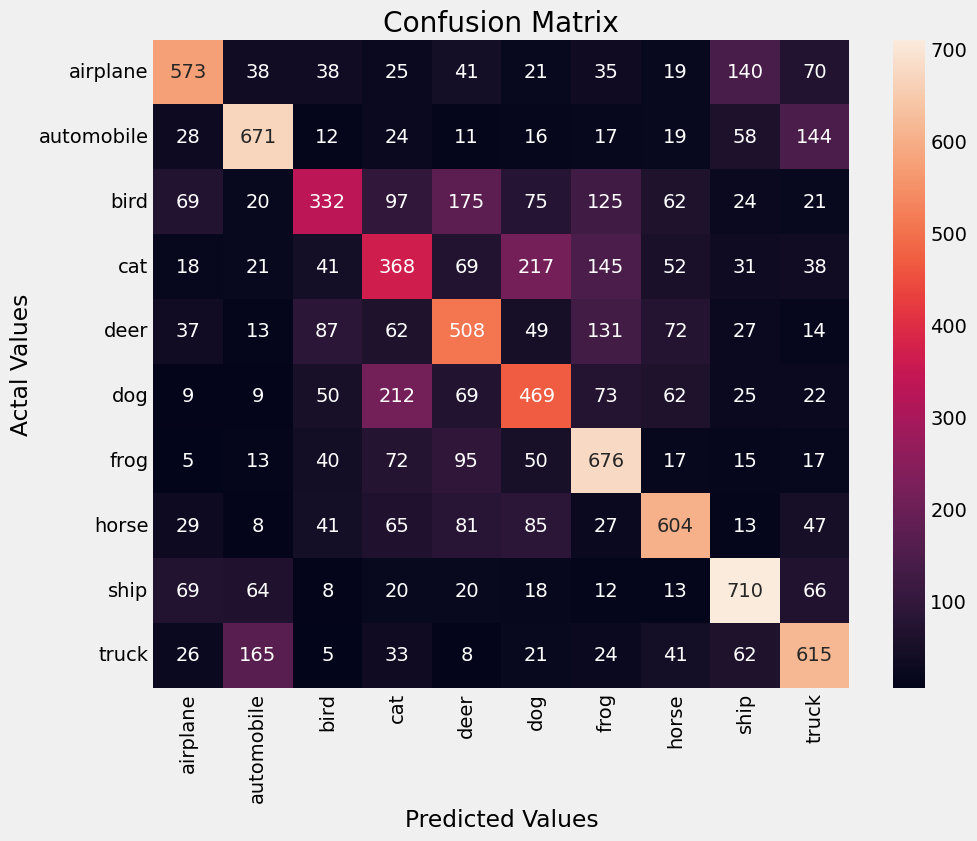

In [34]:
cm = metrics.confusion_matrix(y_test,model_pred)
cm_df = pd.DataFrame(cm,
                     index = uniques, 
                     columns = uniques)
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt = 'g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# b.1 Lets try rmsprop

In [35]:
# Define the model
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
1250/1250 [==============================] - 17s 13ms/step - loss: 2.0464 - accuracy: 0.2571 - val_loss: 1.8413 - val_accuracy: 0.3328
Epoch 2/50
1250/1250 [==============================] - 16s 13ms/step - loss: 1.8818 - accuracy: 0.3125 - val_loss: 1.8351 - val_accuracy: 0.3394
Epoch 3/50
1250/1250 [==============================] - 16s 13ms/step - loss: 1.8318 - accuracy: 0.3379 - val_loss: 1.7620 - val_accuracy: 0.3743
Epoch 4/50
1250/1250 [==============================] - 17s 14ms/step - loss: 1.7986 - accuracy: 0.3494 - val_loss: 1.7781 - val_accuracy: 0.3522
Epoch 5/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.7793 - accuracy: 0.3564 - val_loss: 1.7197 - val_accuracy: 0.3784
Epoch 6/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.7636 - accuracy: 0.3651 - val_loss: 1.6898 - val_accuracy: 0.3920
Epoch 7/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.7549 - accuracy: 0.3710 - val_loss: 1.6979 -

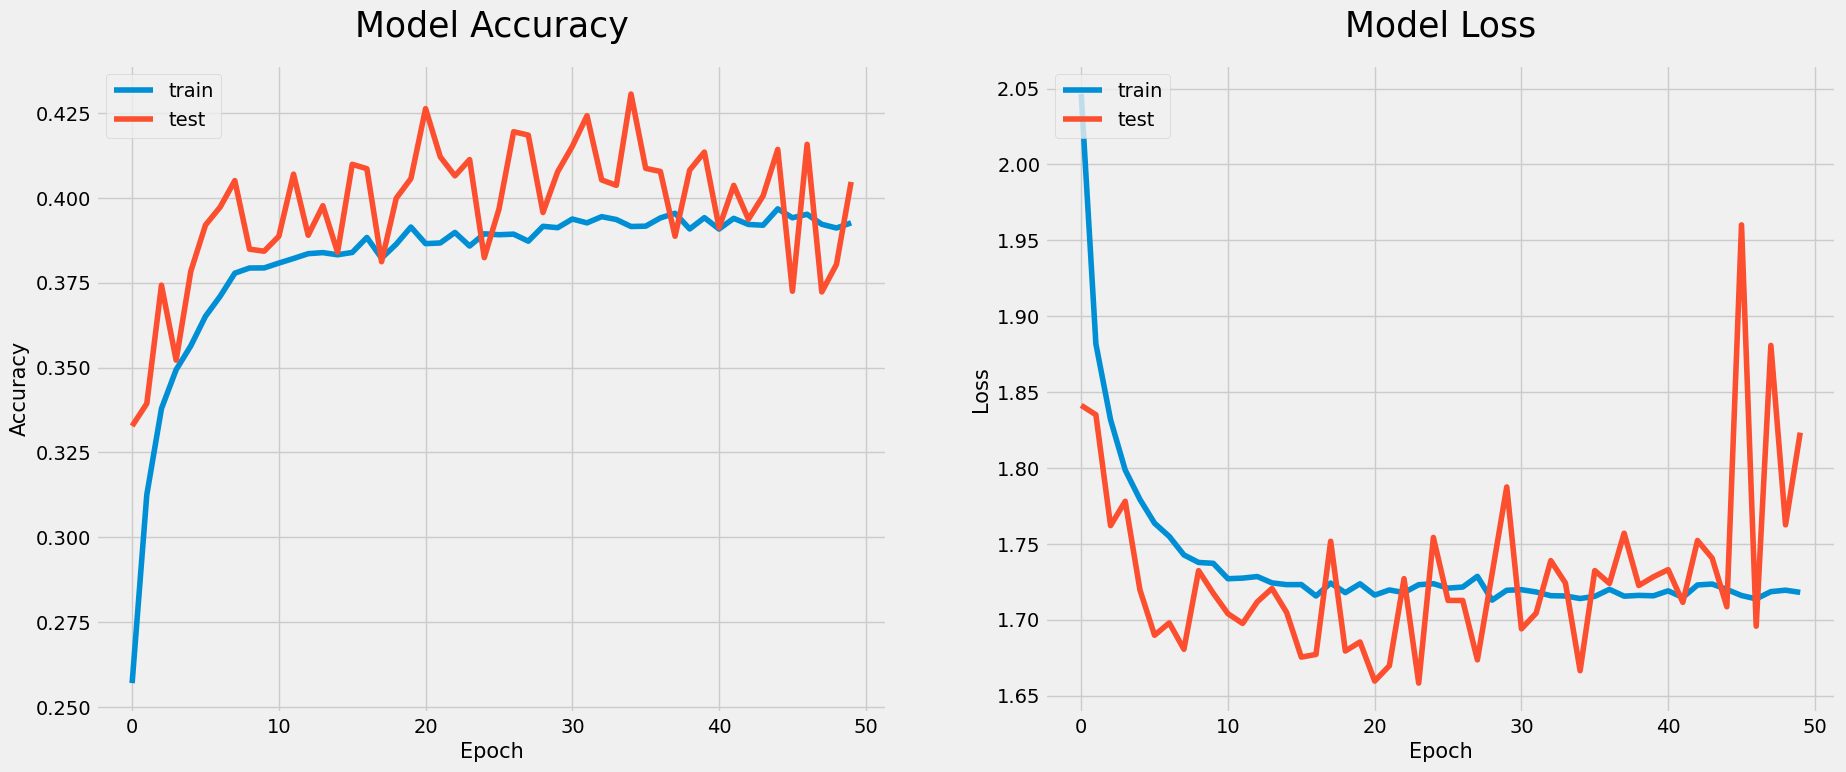

In [36]:
# Plotting the Model Accuracy & Model Loss vs Epochs (Hidden Input)
plt.figure(figsize=[20,8])

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
# Predict probabilities for test set
y_prob = model.predict(X_test)

# Get predicted class labels
model_pred = y_prob.argmax(axis=-1)
print(classification_report(y_test, model_pred)) 

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.47      0.37      0.42      1000
           1       0.56      0.52      0.54      1000
           2       0.26      0.25      0.25      1000
           3       0.28      0.22      0.25      1000
           4       0.28      0.60      0.38      1000
           5       0.47      0.19      0.27      1000
           6       0.47      0.39      0.42      1000
           7       0.41      0.52      0.46      1000
           8       0.45      0.61      0.52      1000
           9       0.59      0.30      0.40      1000

    accuracy                           0.40     10000
   macro avg       0.42      0.40      0.39     10000
weighted avg       0.42      0.40      0.39     10000



# b.1 Lets try adagrad

In [38]:
# Define the model
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adagrad',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
1250/1250 [==============================] - 16s 13ms/step - loss: 2.0655 - accuracy: 0.2489 - val_loss: 1.9068 - val_accuracy: 0.3377
Epoch 2/50
1250/1250 [==============================] - 16s 13ms/step - loss: 1.8998 - accuracy: 0.3190 - val_loss: 1.8433 - val_accuracy: 0.3604
Epoch 3/50
1250/1250 [==============================] - 16s 13ms/step - loss: 1.8403 - accuracy: 0.3481 - val_loss: 1.7932 - val_accuracy: 0.3773
Epoch 4/50
1250/1250 [==============================] - 16s 13ms/step - loss: 1.7943 - accuracy: 0.3663 - val_loss: 1.7558 - val_accuracy: 0.3903
Epoch 5/50
1250/1250 [==============================] - 16s 13ms/step - loss: 1.7668 - accuracy: 0.3784 - val_loss: 1.7331 - val_accuracy: 0.3971
Epoch 6/50
1250/1250 [==============================] - 16s 13ms/step - loss: 1.7405 - accuracy: 0.3857 - val_loss: 1.7124 - val_accuracy: 0.4009
Epoch 7/50
1250/1250 [==============================] - 16s 13ms/step - loss: 1.7181 - accuracy: 0.3934 - val_loss: 1.6902 -

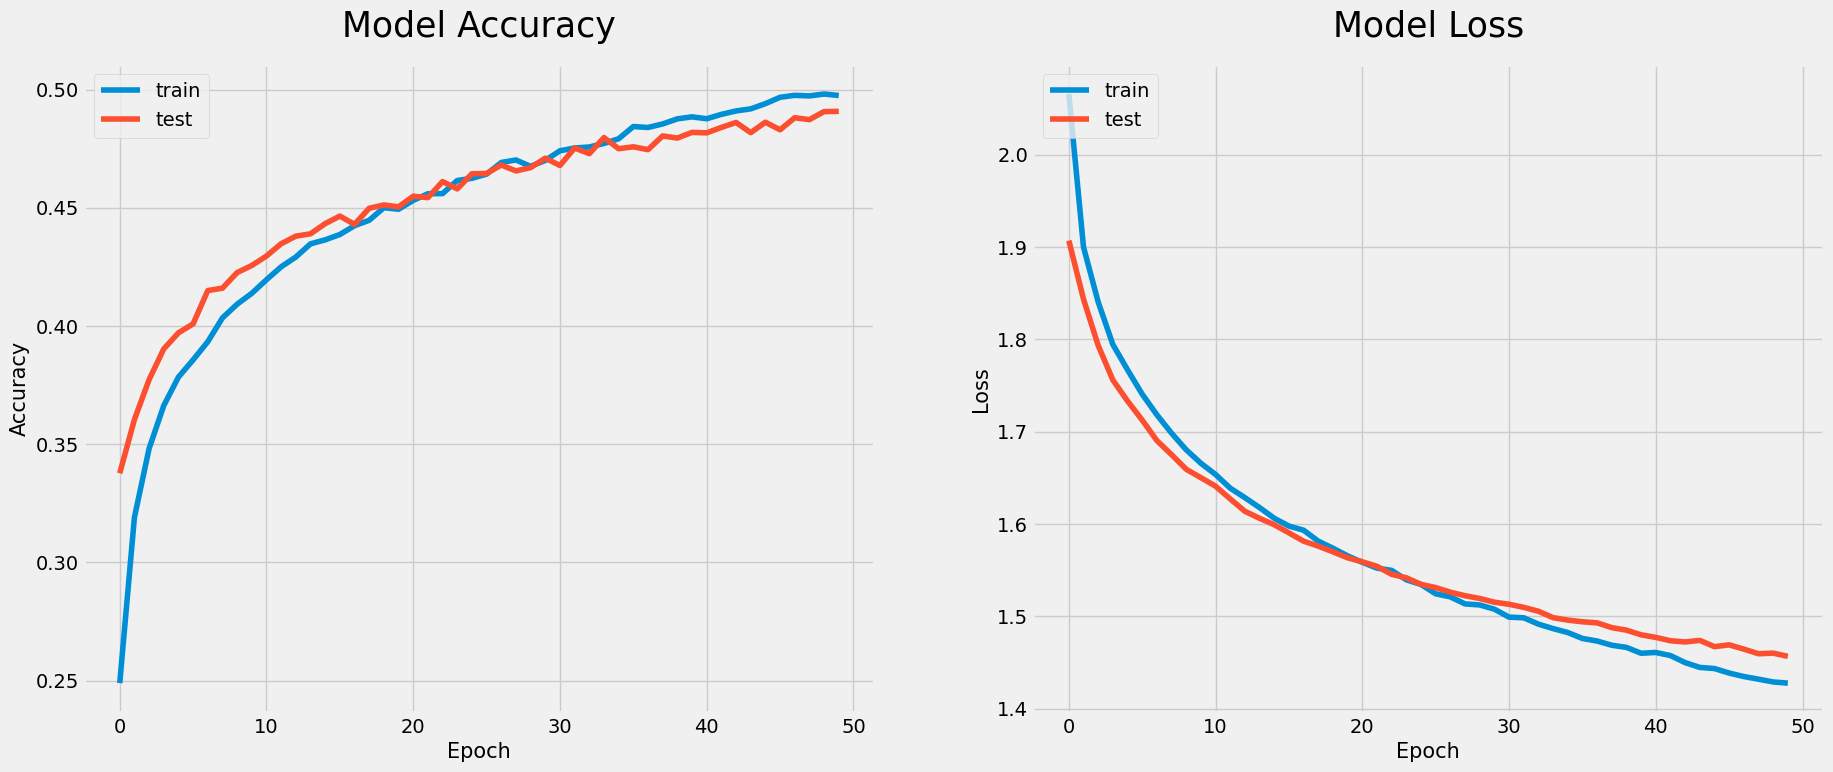

In [39]:
# Plotting the Model Accuracy & Model Loss vs Epochs (Hidden Input)
plt.figure(figsize=[20,8])

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
# Predict probabilities for test set
y_prob = model.predict(X_test)

# Get predicted class labels
model_pred = y_prob.argmax(axis=-1)
print(classification_report(y_test, model_pred)) 

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.56      0.56      0.56      1000
           1       0.57      0.65      0.61      1000
           2       0.36      0.35      0.36      1000
           3       0.37      0.34      0.35      1000
           4       0.47      0.34      0.39      1000
           5       0.44      0.33      0.38      1000
           6       0.48      0.60      0.53      1000
           7       0.53      0.59      0.56      1000
           8       0.60      0.65      0.62      1000
           9       0.54      0.55      0.55      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



# c.select the activation function.

# c.1 Lets try tanh

In [41]:
# Define the model
model = keras.Sequential([
    keras.layers.Dense(512, activation='tanh', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.9854 - accuracy: 0.2882 - val_loss: 1.8551 - val_accuracy: 0.3461
Epoch 2/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.8273 - accuracy: 0.3487 - val_loss: 1.7550 - val_accuracy: 0.3882
Epoch 3/50
1250/1250 [==============================] - 11s 9ms/step - loss: 1.7636 - accuracy: 0.3728 - val_loss: 1.6998 - val_accuracy: 0.4098
Epoch 4/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.7155 - accuracy: 0.3914 - val_loss: 1.6605 - val_accuracy: 0.4157
Epoch 5/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6848 - accuracy: 0.4024 - val_loss: 1.6697 - val_accuracy: 0.4090
Epoch 6/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6608 - accuracy: 0.4121 - val_loss: 1.6482 - val_accuracy: 0.4141
Epoch 7/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6397 - accuracy: 0.4208 - val_loss: 1.6316 - val_ac

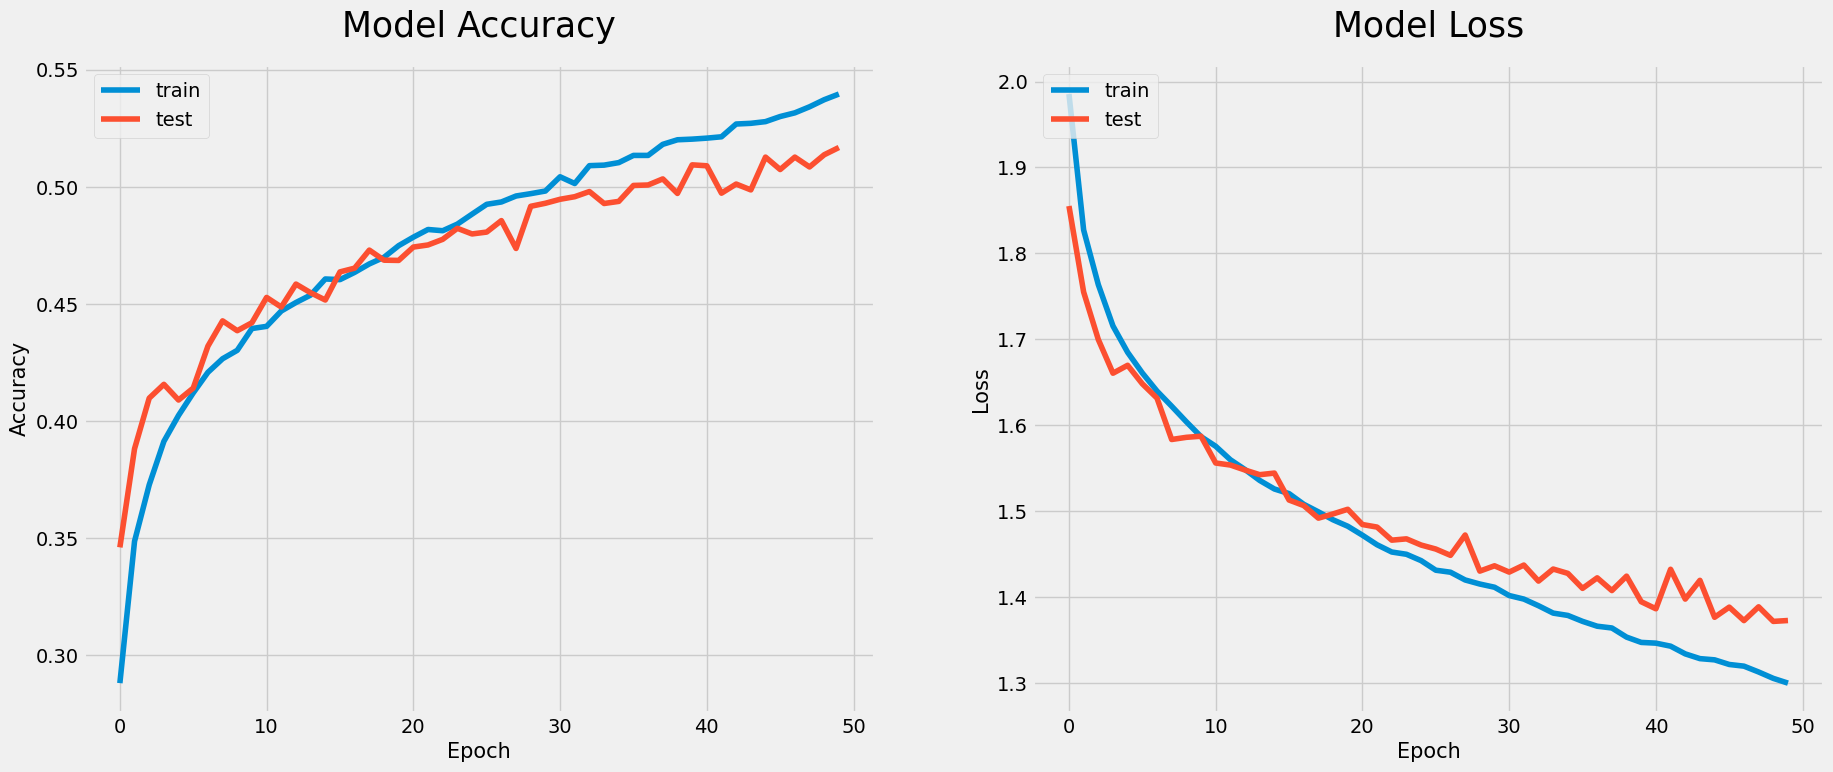

In [42]:
# Plotting the Model Accuracy & Model Loss vs Epochs (Hidden Input)
plt.figure(figsize=[20,8])

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
# Predict probabilities for test set
y_prob = model.predict(X_test)

# Get predicted class labels
model_pred = y_prob.argmax(axis=-1)
print(classification_report(y_test, model_pred)) 

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.55      0.64      0.59      1000
           1       0.65      0.58      0.61      1000
           2       0.51      0.28      0.36      1000
           3       0.37      0.26      0.30      1000
           4       0.53      0.37      0.44      1000
           5       0.40      0.45      0.43      1000
           6       0.49      0.67      0.57      1000
           7       0.55      0.62      0.58      1000
           8       0.63      0.66      0.65      1000
           9       0.50      0.67      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.51     10000
weighted avg       0.52      0.52      0.51     10000



# c.2 Lets try sigmoid

In [44]:
# Define the model
model = keras.Sequential([
    keras.layers.Dense(512, activation='sigmoid', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='sigmoid'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
1250/1250 [==============================] - 10s 8ms/step - loss: 2.3087 - accuracy: 0.1274 - val_loss: 2.1997 - val_accuracy: 0.2196
Epoch 2/50
1250/1250 [==============================] - 10s 8ms/step - loss: 2.1799 - accuracy: 0.1861 - val_loss: 2.0879 - val_accuracy: 0.2559
Epoch 3/50
1250/1250 [==============================] - 10s 8ms/step - loss: 2.0820 - accuracy: 0.2258 - val_loss: 2.0150 - val_accuracy: 0.2779
Epoch 4/50
1250/1250 [==============================] - 10s 8ms/step - loss: 2.0257 - accuracy: 0.2533 - val_loss: 1.9739 - val_accuracy: 0.3000
Epoch 5/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.9883 - accuracy: 0.2708 - val_loss: 1.9424 - val_accuracy: 0.3083
Epoch 6/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.9647 - accuracy: 0.2833 - val_loss: 1.9200 - val_accuracy: 0.3146
Epoch 7/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.9392 - accuracy: 0.2969 - val_loss: 1.9067 - val_ac

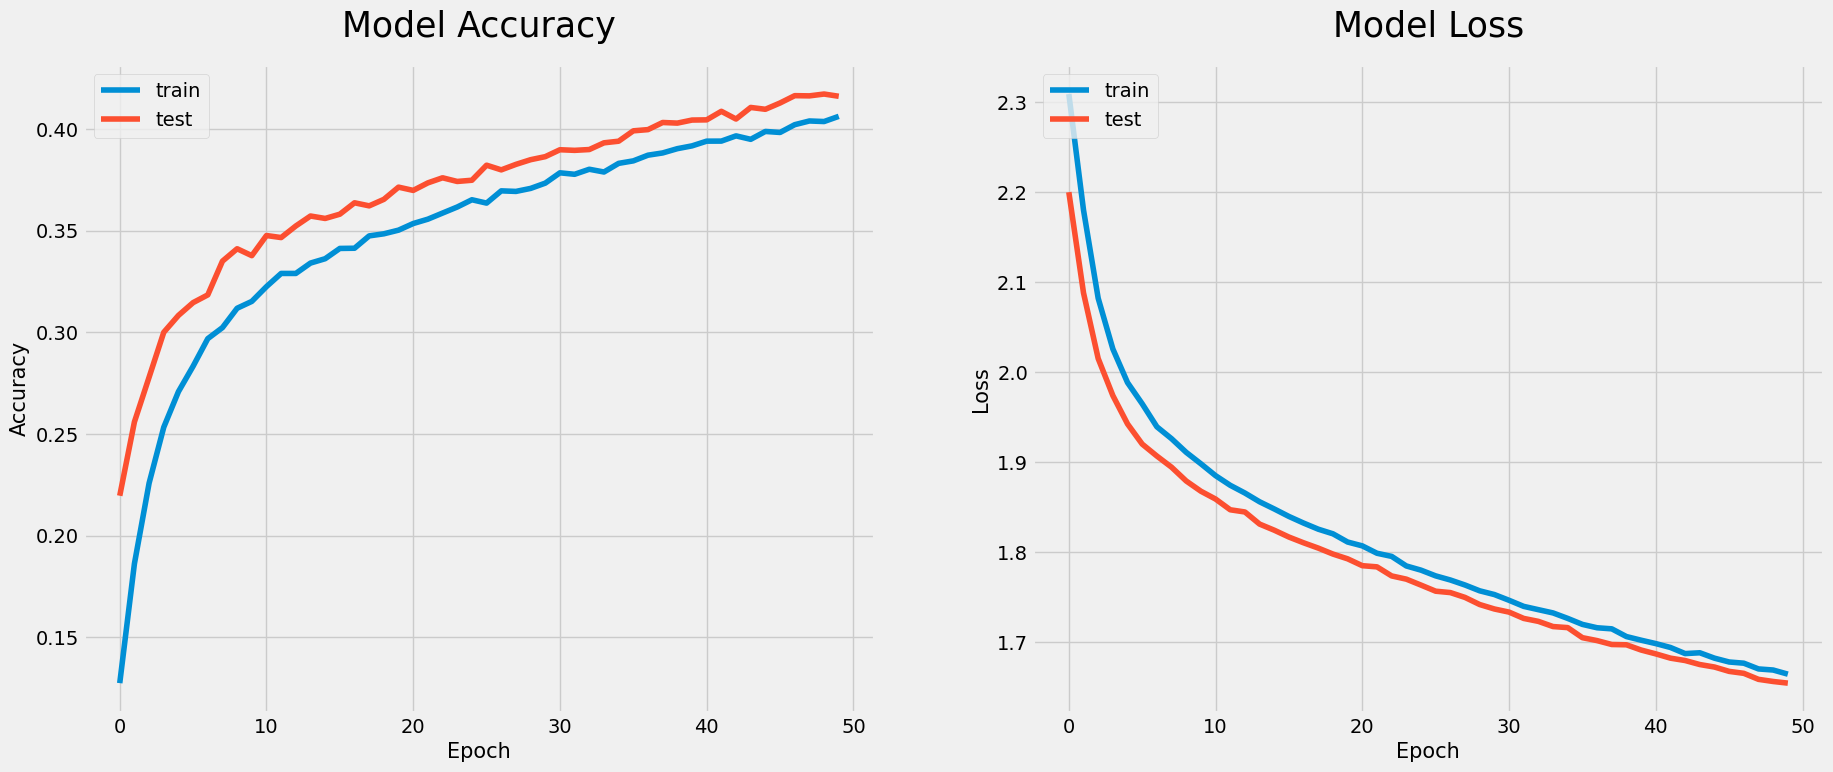

In [45]:
# Plotting the Model Accuracy & Model Loss vs Epochs (Hidden Input)
plt.figure(figsize=[20,8])

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
# Predict probabilities for test set
y_prob = model.predict(X_test)

# Get predicted class labels
model_pred = y_prob.argmax(axis=-1)
print(classification_report(y_test, model_pred)) 

313/313 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.51      0.45      0.47      1000
           1       0.53      0.51      0.52      1000
           2       0.28      0.33      0.31      1000
           3       0.30      0.23      0.26      1000
           4       0.39      0.29      0.33      1000
           5       0.40      0.31      0.35      1000
           6       0.39      0.59      0.47      1000
           7       0.50      0.43      0.46      1000
           8       0.48      0.60      0.53      1000
           9       0.46      0.50      0.48      1000

    accuracy                           0.42     10000
   macro avg       0.42      0.42      0.42     10000
weighted avg       0.42      0.42      0.42     10000



# 9. Compare the performance of classification algorithms using tables and graphs.

In [47]:
df = pd.read_excel(r"C:\Users\aliha\Desktop\model_comparison.xlsx")
df

,Model,Accuracy,Precision,Recall
0,SVM,0.52,0.51,0.52
1,KNN,0.34,0.39,0.34
2,Neural Network,0.54,0.54,0.54


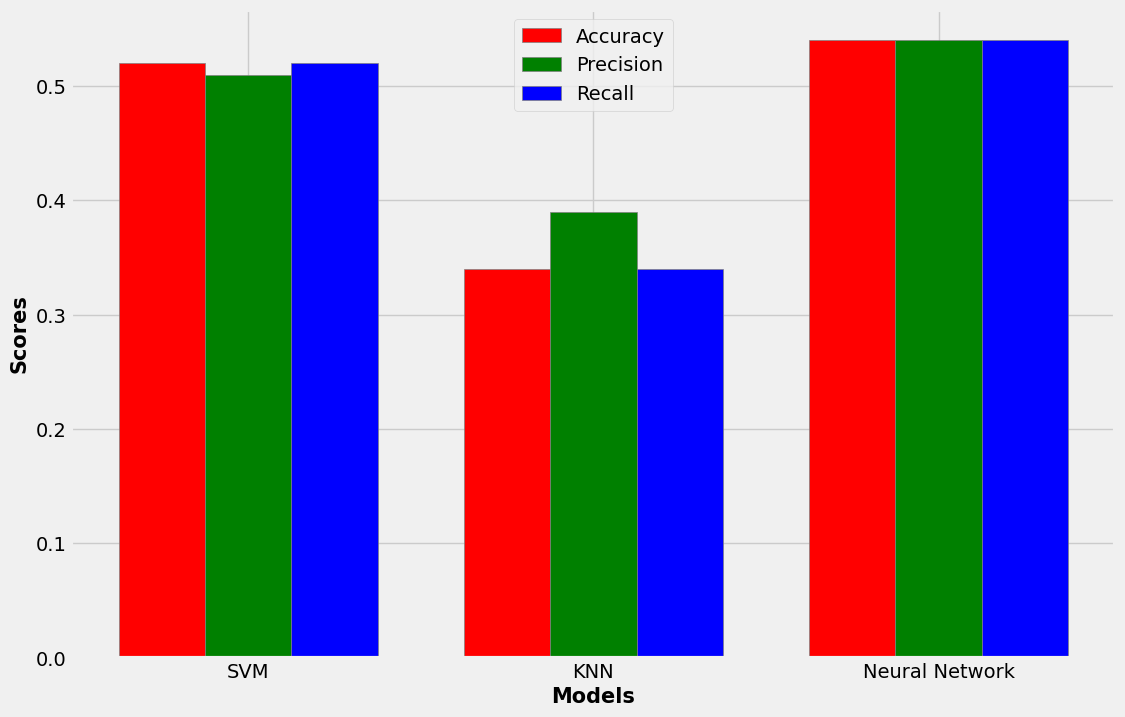

In [48]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
accuracy = df['Accuracy']
precision = df['Precision']
recall = df['Recall']
 
# Set position of bar on X axis
br1 = np.arange(len(accuracy))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, accuracy, color ='r', width = barWidth,
        edgecolor ='grey', label ='Accuracy')
plt.bar(br2, precision, color ='g', width = barWidth,
        edgecolor ='grey', label ='Precision')
plt.bar(br3, recall, color ='b', width = barWidth,
        edgecolor ='grey', label ='Recall')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('Scores', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(accuracy))],
           df['Model'])
 
plt.legend()
plt.show()

# The rest in the report